Below we provide an implementation of a system that helps cab drivers to direct toward the best location for upcoming requests.

We use a simple approach. The map of the city is seen as a chess board. For each cell in the map we build a model based on historical data. We consider weekdays separately since the distribution of request may vary.

Note that the current notebook needs some data created from the co2_prediction notebook. Run that one first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import random as rnd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import itertools
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
# Load preformatted table
cabs_data = pd.read_csv("./processed_data/cabs_data.csv")
sample_data = cabs_data[cabs_data.pick_up==1]

Below we set the boundaries of the map. We divide the map into 100 cells. This approach is flexible, the map can be divided according to the map of city roads. Also, we may think to increase cell granularities around highly served locations. Or identify clusters of locations, hence mapping the city to a network of cells. here for simplicity we apply a simple approach. 

In [3]:
# Set the boundaries of the map
min_long = -122.55
max_long = -122.2
min_lat = 37.4
max_lat = 37.9

lag = 10
time_window = 64

In [4]:
enc = KBinsDiscretizer(n_bins=lag, encode='ordinal')
X = enc.fit_transform(sample_data[['longitude', 'latitude']])
sample_data = sample_data.assign(cell = ['-'.join(x) for x in X.astype(int).astype(str)])

Auto-Regressive Integrated Moving Averages (ARIMA) are commonly adopted to model this type of problems. We tried to fit an ARIMA model that accounts for the seasonality in the data. Results weren't convincing, probably due to the different distribution of requests between business days and weekend days. For lack of time I decided to swith to a rather simple approach, still I believe appropriate to solve the problem.

Our approach is rather simple. A polinomial curve (4 parameters) is fit to the data for each cell of the map and for each day of the week. Then for each

In [5]:
sample_data['datetime'] = pd.to_datetime(sample_data['time'])
sample_data.index = sample_data['datetime'] 

Below we overfit the distribution of the number of the total number requests grouped in 24h. We clearly see a pseudo-sinusoidal trend.

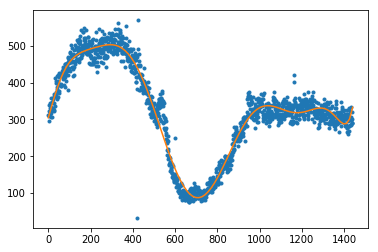

In [6]:
y = sample_data.groupby(by=['hour', 'minute'])["pick_up"].sum().reset_index()

x = y.hour*60+y.minute
yy = y.pick_up

z = np.polyfit(x, yy, 10)
p = np.poly1d(z)
xp = np.linspace(0, y.shape[0], 100)
_ = plt.plot(x, yy, '.', xp, p(xp), '-')

Below we repeat the plot above fixing a cell and a day of the week.

In [7]:
tab = sample_data.groupby(by=['day', 'cell', 'hour'])['pick_up'].sum().reset_index()

In [8]:
tab.head()

,day,cell,hour,pick_up
0,0,0-0,0,29
1,0,0-0,1,21
2,0,0-0,2,28
3,0,0-0,3,24
4,0,0-0,4,17


Below an example of request distributions over a day, for a cell and 3 different weekdays.

Not implemented:
Given a cab position in the map and a time, the system computes the time needed to reach other cells in the map. Then interrogating the fitted curves will be possible to compute the expected number of request per cell are a given time.

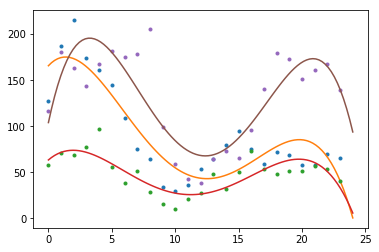

In [9]:
for day in [0,1,6]:
    for cell in ['0-2']:
        y = tab[np.logical_and(tab.day==day, tab.cell==cell)]
        z = np.polyfit(y.hour, y.pick_up, 4)
        p = np.poly1d(z)
        xp = np.linspace(0, y.shape[0], 100)
        _ = plt.plot(y.hour, y.pick_up, '.', xp, p(xp), '-')

Scatter plot of requests per day and hour.

     latitude  longitude
174  37.61787 -122.38572


(37.4, 37.9)

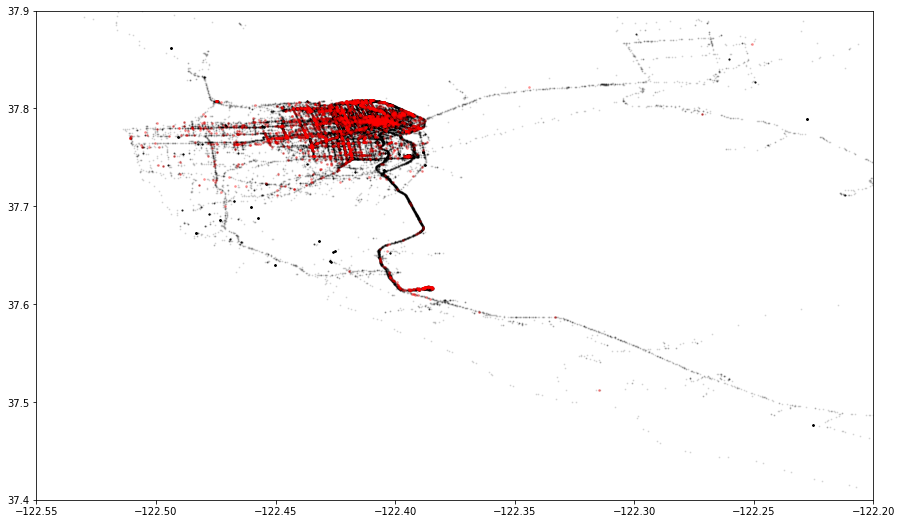

In [10]:
def extract_locations(cabs_data, day, hour, val):
    tf = np.logical_and(cabs_data.day==day, cabs_data.hour==hour)
    tf = np.logical_and(tf, cabs_data.pick_up==val)
    
    x = cabs_data.longitude[tf]
    y = cabs_data.latitude[tf]
    z = cabs_data.pick_up[tf]
    return x, y, z

day=0
hour=0

idx = rnd.sample(range(0, 1000), 1)
geo_coord = cabs_data.iloc[idx][['latitude', 'longitude']]
print(geo_coord)

plt.figure(figsize = (15,9))
x, y, z = extract_locations(cabs_data, day, hour, val=0)
plt.scatter(x, y, c="k", s=1, alpha=0.1)

x, y, z = extract_locations(cabs_data, day, hour, val=1)
plt.scatter(x, y, c="r", s=3, alpha=0.3)

#plt.xlim([geo_coord.longitude.values-0.05, geo_coord.longitude.values+0.05])
#plt.ylim([geo_coord.latitude.values-0.05, geo_coord.latitude.values+0.05])

plt.xlim([min_long, max_long])
plt.ylim([min_lat, max_lat])
